# Nearest Neighbour Analysis


One commonly used GIS task is to be able to find the nearest neighbour for an object or a set of objects. For instance, you might have a single Point object
representing your home location, and then another set of locations representing e.g. public transport stops. Then, quite typical question is *"which of the stops is closest one to my home?"*
This is a typical nearest neighbour analysis, where the aim is to find the closest geometry to another geometry.

In Python this kind of analysis can be done with shapely function called ``nearest_points()`` that [returns a tuple of the nearest points in the input geometries](https://shapely.readthedocs.io/en/latest/manual.html#shapely.ops.nearest_points).

## Nearest point using Shapely


Let's start by testing how we can find the nearest Point using the ``nearest_points()`` function of Shapely.

- Let's create an origin Point and a few destination Points and find out the closest destination:




In [1]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# Origin point
orig = Point(1, 1.67)

# Destination points
dest1 = Point(0, 1.45)
dest2 = Point(2, 2)
dest3 = Point(0, 2.5)

To be able to find out the closest destination point from the origin, we need to create a MultiPoint object from the destination points.

In [2]:
destinations = MultiPoint([dest1, dest2, dest3])

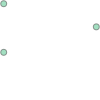

In [3]:
destinations

Okey, now we can see that all the destination points are represented as a single MultiPoint object.

- Now we can find out the nearest destination point by using ``nearest_points()`` function:


In [16]:
nearest = nearest_points(orig, destinations)
print(nearest[0])
print(nearest[1])


POINT (1 1.67)
POINT (0 1.45)


- We can check the data type of this object and confirm that the ``nearest_points()`` function returns a tuple of nearest points:

 - let's check the contents of this tuple:

In the tuple, the first item (at index 0) is the geometry of our origin point and the second item (at index 1) is the actual nearest geometry from the destination points. Hence, the closest destination point seems to be the one located at coordinates (0, 1.45).

This is the basic logic how we can find the nearest point from a set of points.

## Nearest points using Geopandas

Let's then see how it is possible to find nearest points from a set of origin points to a set of destination points using GeoDataFrames. Here, we will use the ``PKS_suuralueet.kml`` district data, and the ``addresses.shp`` address points from previous sections. 



**Our goal in this tutorial is to find out the closest address to the centroid of each district.**

- Let's first read in the data and check their structure:

In [17]:
# Import geopandas
import geopandas as gpd

In [18]:
# Define filepaths
fp1 = "data/PKS_suuralue.kml"
fp2 = "data/addresses.shp"

In [55]:
# Enable KML driver
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [56]:
# Read in data with geopandas
df1 = gpd.read_file(fp1, driver='KML')
df2 = gpd.read_file(fp2)

In [57]:
# District polygons:
df1.head()

,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."


<AxesSubplot:>

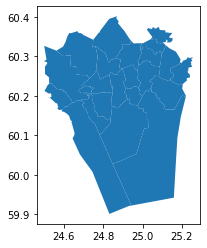

In [59]:
df1.plot()

In [24]:
# Address points:
df2.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


<AxesSubplot:>

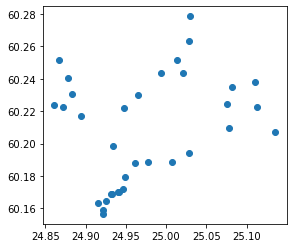

In [61]:
df2.plot()

Before calculating any distances, we should re-project the data into a projected crs.

In [62]:
df1 = df1.to_crs(epsg='3067')
df2 = df2.to_crs(epsg='3067')

Furthermore, let's calculate the centroids for each district area:

In [63]:
df1['centroid'] = df1.centroid

<AxesSubplot:>

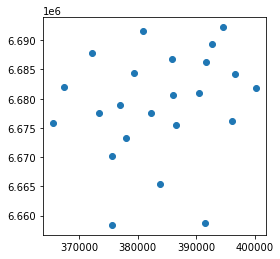

In [64]:
df1['centroid'].plot()

SO, for each row of data in the disctricts -table, we want to figure out the nearest address point and fetch some attributes related to that point. In other words, we want to apply the Shapely `nearest_points`function so that we compare each polygon centroid to all address points, and based on this information access correct attribute information from the address table. 

For doing this, we can create a function that we will apply on the polygon GeoDataFrame:

In [37]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

By default, this function returns the geometry of the nearest point for each row. It is also possible to fetch information from other columns by changing the `value_column` parameter.

The function creates a MultiPoint object from `other_gdf` geometry column (in our case, the address points) and further passes this MultiPoint object to Shapely's `nearest_points` function. 

Here, we are using a method for creating an union of all input geometries called `unary_union`. 

- Let's check how unary union works by applying it to the address points GeoDataFrame:

In [45]:
unary_union = df2.unary_union

Okey now we are ready to use our function and find closest address point for each polygon centroid.
 - Try first applying the function without any additional modifications: 

In [48]:
df1.apply(get_nearest_values, other_gdf = df2, point_column='centroid', value_column="geometry", axis = 1)

C:\Users\mando\.conda\envs\python-gis\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0     POINT (384632.93678170093 6670672.153797519)
1      POINT (381504.3527144172 6678280.815110135)
2     POINT (381939.56820559036 6681352.997412824)
3     POINT (381939.56820559036 6681352.997412824)
4     POINT (384320.89827964845 6671412.394772961)
5      POINT (381504.3527144172 6678280.815110135)
6      POINT (381504.3527144172 6678280.815110135)
7      POINT (381504.3527144172 6678280.815110135)
8     POINT (381939.56820559036 6681352.997412824)
9     POINT (381939.56820559036 6681352.997412824)
10    POINT (384632.93678170093 6670672.153797519)
11    POINT (384632.93678170093 6670672.153797519)
12    POINT (385486.63769903884 6675317.531513787)
13     POINT (382114.9792119076 6678084.618272202)
14    POINT (387329.01954235986 6678742.357557865)
15    POINT (390024.58270165697 6681059.205512979)
16    POINT (391058.43854379095 6684060.674573047)
17    POINT (391058.43854379095 6684060.674573047)
18    POINT (391058.43854379095 6684060.674573047)
19     POINT (396679.3026471605

- Finally, we can specify that we want the `id` -column for each point, and store the output in a new column `"nearest_loc"`:

In [50]:
df1['nearest_station'] = df1.apply(get_nearest_values, other_gdf = df2, point_column='centroid', value_column="id", axis = 1)

In [51]:
df1.head()

,Name,Description,geometry,centroid,nearest_station
0,Suur-Espoonlahti,,"POLYGON ((376322.317 6665639.417, 376401.244 6...",POINT (375676.529 6658405.261),1005
1,Suur-Kauklahti,,"POLYGON ((367726.077 6673018.023, 367715.245 6...",POINT (365520.906 6675893.101),1020
2,Vanha-Espoo,,"POLYGON ((371207.712 6677289.881, 371174.739 6...",POINT (367400.175 6681941.088),1017
3,Pohjois-Espoo,,"POLYGON ((376528.523 6683480.345, 376638.253 6...",POINT (372191.037 6687785.458),1017
4,Suur-Matinkylä,,"POLYGON ((375347.271 6672052.630, 375354.852 6...",POINT (375678.189 6670243.076),1000


That's it! Now we found the closest point for each centroid and got the ``id`` value from our addresses into the ``df1`` GeoDataFrame.
